In [1]:
import pandas_datareader.data as web  # module for reading datasets directly from the web
#pip install pandas-datareader (in case you haven't install this package)
from pandas_datareader.famafrench import get_available_datasets
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import statsmodels.api as sm
import scipy as sp
from dateutil.relativedelta import relativedelta
import datapungibea as dpb
import os
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import seaborn as sns
import re

In [66]:
###########################
#Customize your data selection
###########################
#It is important to check the description of the dataset we access by using the following codes 
sdate='1969-01-01'
edate='2018-12-31'
dir = os.path.realpath('.')

In [67]:
filename = os.path.join(dir, 'Data','ie_data.xls')
dfPE = pd.read_excel(filename,sheet_name='Data',header=None)  
dfPE=dfPE.iloc[:,[0,1,2]].dropna()
headers = dfPE.iloc[0]
Shiller_df  = pd.DataFrame(dfPE.values[1:], columns=headers)

pattern = re.compile("^\d{4}\.[1]$")
Shiller_df['Date'] = Shiller_df['Date'].apply(lambda x:dt.datetime.strptime(str(x),'%Y.%m') if not bool(pattern.match(str(x))) else dt.datetime.strptime((str(x)+'0'),'%Y.%m'))
Shiller_df=Shiller_df[(Shiller_df['Date']>= pd.to_datetime(sdate)) & (Shiller_df['Date']<= pd.to_datetime(edate))]
Shiller_df = Shiller_df.set_index('Date')
Shiller_df = Shiller_df[Shiller_df.index.month==12]

In [68]:
Shiller_df['dd']=Shiller_df['D'].diff()/Shiller_df['D'].shift(1)
Shiller_df['dp'] = Shiller_df['D']/Shiller_df['P']
Shiller_df['vwretd'] = (Shiller_df['P']+Shiller_df['D'])/Shiller_df['P'].shift(1)-1
Shiller_df = Shiller_df.dropna()
Shiller_df=Shiller_df.astype(float)
del Shiller_df.columns.name
# Shiller_df = Shiller_df.resample('Y').mean()

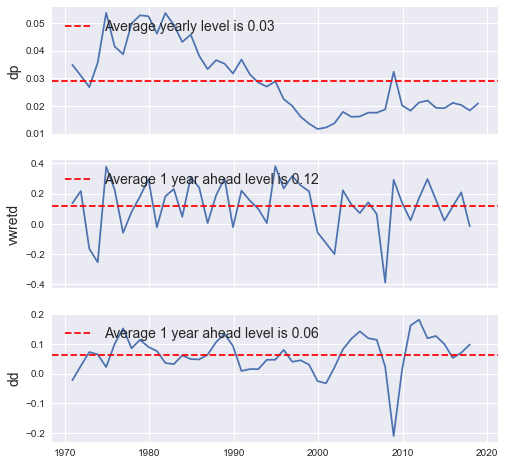

In [84]:
###########################
#Plot out the graphs
###########################
#See this link for detailed guidance on date ticks
# https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/date.html
# I am troubled by adjusting the format and making subplots for the whole evening and it turns out that things can be simplified in the following way:
years_fmt = mdates.DateFormatter('%Y')
#This will be used as input to adjust the axis label to be in the unit of year
n = len(Shiller_df[['dp','vwretd','dd']].columns)
fig, axes = plt.subplots(n,1,figsize=(8,8),sharex=True)
#Using sharex help making the plot simple and easy to read
# Create fig and axes class so I can then process with them in the for loop.
# fig.suptitle('Time series of relevant variables',fontsize=16)
for k,factortitle in enumerate(Shiller_df[['dp','vwretd','dd']].columns):
    ax = axes[k]
    if factortitle == 'dp':
        ax.plot(Shiller_df.index,Shiller_df[factortitle])
        ax.axhline(y=Shiller_df[factortitle].mean(),color='r', linestyle='--',label='Average yearly level is {:.2f}'.format(Shiller_df[factortitle].mean()))
    else:
        ax.plot(Shiller_df.index,Shiller_df[factortitle].rolling(1).mean().shift(-1))
        ax.axhline(y=Shiller_df[factortitle].mean(),color='r', linestyle='--',label='Average 1 year ahead level is {:.2f}'.format(Shiller_df[factortitle].mean()))
    ax.xaxis.set_major_formatter(years_fmt)
    ax.set_ylabel(factortitle,fontsize = 14)
    ax.legend(fontsize = 14,loc=2)
plotname = os.path.join(dir, 'Graph','Time series of S&P yearly return and DP ratio')
plt.savefig(plotname)
plt.show()

In [90]:
######
# Cochrane 2005 table 
######
def Cochrane_2005PR(dftest, horizons=[year*1 for year in [1,2,3,5]],x_name='dd',y_name='vwretd'):
    dfreturn = pd.DataFrame(columns=['x','y'])
    ceof_dic= {'beta':[],'t':[],'R^2':[]}
    for h in horizons:
        dfreturn['x'] = dftest[x_name]
        dfreturn['y'] = dftest[y_name].rolling(h).sum().shift(-h)/(h)   
        dfreturn=dfreturn.dropna()
        X = sm.add_constant(dfreturn['x'])
        y = dfreturn['y']
        model = sm.OLS(y, X)
        results = model.fit()
        ceof_dic['beta'].append(np.round(results.params[1:][0],2))
        ceof_dic['t'].append(np.round(results.tvalues[1:][0],2))
        ceof_dic['R^2'].append(np.round(results.rsquared,4))
    ceof_dic = pd.DataFrame.from_dict(ceof_dic).T
    ceof_dic.columns = horizons
    return ceof_dic

In [91]:
dppredictiontable = Cochrane_2005PR(Shiller_df)
print(dppredictiontable.round(2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &     1 &     2 &     3 &     5 \\
\midrule
beta &  0.12 &  0.28 &  0.18 & -0.05 \\
t    &  0.33 &  1.03 &  0.87 & -0.32 \\
R\textasciicircum 2  &  0.00 &  0.02 &  0.02 &  0.00 \\
\bottomrule
\end{tabular}



#### Alternatively, can check out cochrane's estimates using data from wrds

In [115]:
######
# Cochrane 2005 table
######
def Cochrane_2005PR(dftest, horizons=[year*12 for year in [1,2,3,5]],x_name='CAPE',y_name='Mkt'):
    dfreturn = pd.DataFrame(columns=['x','y'])
    ceof_dic= {'beta':[],'t':[],'R^2':[]}
    for h in horizons:
        dfreturn['x'] = dftest[x_name]
        dfreturn['y'] = dftest[y_name].rolling(h).sum().shift(-h)/12
        dfreturn=dfreturn.dropna()
        X = sm.add_constant(dfreturn['x'])
        y = dfreturn['y']
        model = sm.OLS(y, X)
        results = model.fit()
        ceof_dic['beta'].append(np.round(results.params[1:][0],2))
        ceof_dic['t'].append(np.round(results.tvalues[1:][0],2))
        ceof_dic['R^2'].append(np.round(results.rsquared,4))
    ceof_dic = pd.DataFrame.from_dict(ceof_dic).T
    ceof_dic.columns = horizons
    return ceof_dic

In [93]:
filename = os.path.join(dir, 'Cochrane','vwr.txt')
data = data = pd.read_csv(filename, sep="\s+", header = None,skiprows=2,index_col=0,parse_dates =[0])
data.columns = ["vwretd", "vwretx"]
data['dp'] = (data['vwretd']+1)/(data['vwretx']+1)-1
data['dp-1'] = (data['vwretd']-data['vwretx'])
data['dd'] = data['dp-1']/data['dp-1'].shift(1)*(data['vwretx']+1).shift(1)
data['vwretdnext'] = data['vwretd'].shift(-1)

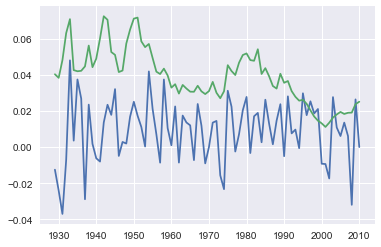

In [95]:
X = sm.add_constant(data['dp'].resample('1Y').first())
y = data['vwretdnext'].resample('1Y').sum()
model = sm.OLS(y, X)
results = model.fit()
plt.plot(y/12)
plt.plot(X['dp'])

In [45]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             vwretdnext   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     4.782
Date:                Sun, 07 Feb 2021   Prob (F-statistic):             0.0317
Time:                        16:43:01   Log-Likelihood:                 16.372
No. Observations:                  82   AIC:                            -28.74
Df Residuals:                      80   BIC:                            -23.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0177      0.062     -0.286      0.7

In [96]:
######
# Cochrane 2005 table
######
def Cochrane_2005PR(dftest, horizons=[1,2,3,5],x_name='dp',y_name='vwretd'):
    dfreturn = pd.DataFrame(columns=['x','y'])
    ceof_dic= {'beta':[],'t':[],'R^2':[]}
    for h in horizons:
        dfreturn['x'] = dftest[x_name]
        dfreturn['y'] = dftest[y_name].rolling(h).sum().shift(-h)/h
        dfreturn=dfreturn.dropna()
        X = sm.add_constant(dfreturn['x'])
        y = dfreturn['y']
        model = sm.OLS(y, X)
        results = model.fit()
        ceof_dic['beta'].append(np.round(results.params[1:][0],2))
        ceof_dic['t'].append(np.round(results.tvalues[1:][0],2))
        ceof_dic['R^2'].append(np.round(results.rsquared,4))
    ceof_dic = pd.DataFrame.from_dict(ceof_dic).T
    ceof_dic.columns = horizons
    return ceof_dic

In [97]:
Cochrane_2005PR(data)

,1,2,3,5
beta,3.1900,3.0400,2.8200,2.4300
t,2.1300,2.9100,3.5400,4.9000
R^2,0.0543,0.0979,0.1399,0.2428
